# Hull-White (One Factor Model)

Assumptions: Speed of reversion is constant $\alpha$, the volatility is constant $\sigma$
Features:  Reversion level is time dependent, $\theta(t)$ is chosen to make the model consistent with the initial term structure

https://youtu.be/fCwa12lFb1M?si=WP6cW2VKUzXuLwZI (Based on Reference 2)


$$
D_r = \alpha[\frac{\theta(t)}{\alpha}-r]dt + \sigma dz
$$

$$
\theta(t)=F_t(0, t)+a F(0, t)+\frac{\sigma^2}{2 a}\left(1-e^{-2 a t}\right)
$$


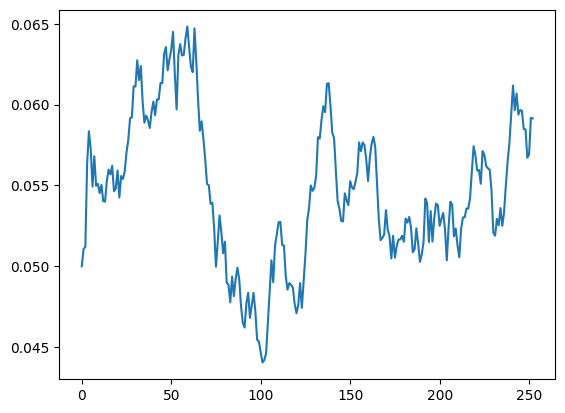

In [446]:
import numpy as np
import matplotlib.pyplot as plt

# Dummy version with fixed theta term, therefore does not support calibration
def hull_white_one_factor(r0, alpha, theta, sigma, dt, num_steps):
    rates = [r0]
    for _ in range(num_steps):
        dr = alpha * (theta - rates[-1]) * dt + sigma * np.sqrt(dt) * np.random.normal()    # Last value is always previous
        rates.append(rates[-1] + dr)
    return np.array(rates)


# Parameters
r0 = 0.05
alpha = 0.1
theta = 0.05
sigma = 0.02
dt = 1/252.0
num_steps = 252

rate_path_HW = hull_white_one_factor(r0, alpha, theta, sigma, dt, num_steps)
plt.plot(rate_path_HW)


# Complete

Very rough implementation, probably wrong

Sources, besides the papers provided, which are in the folder:
https://www.youtube.com/watch?v=A1Ac9I8j-wY&ab_channel=VuTienVo
https://www.youtube.com/watch?v=Q4vfoDUkTsM&ab_channel=finmath

Bermudan Swaption Price: 0.05937248


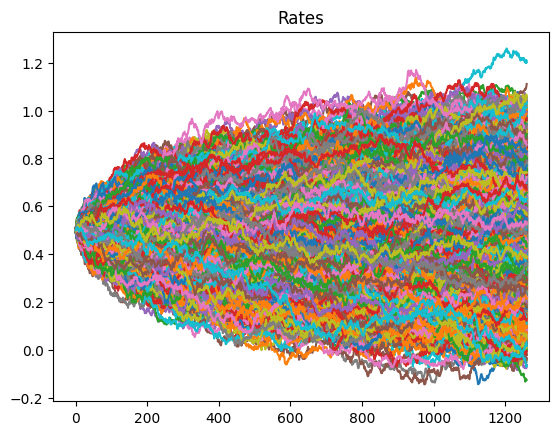

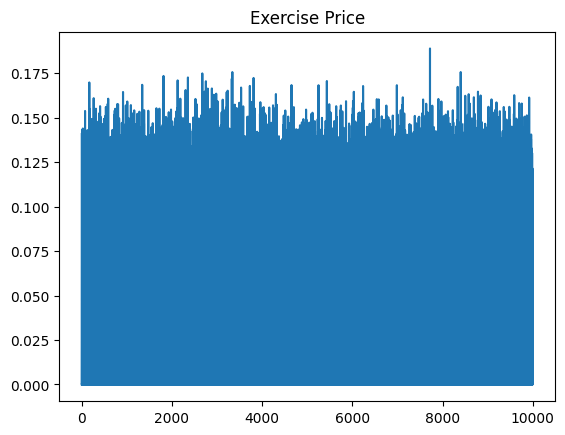

In [657]:
import numpy as np
from sklearn.linear_model import LinearRegression

def simulate_rate_paths(r0, sigma, alpha, theta, dt, n_steps, n_simulations):
    """
    Simulate the underlying rate paths using a geometric Brownian motion model.
    
    Parameters:
    - r0: initial interest rate
    - sigma: volatility of the interest rate
    - alpha: parameter for White-Hull Model
    - theta: parameter for White-Hull Model
    - dt: time step size
    - n_steps: number of steps
    - n_simulations: number of rate path simulations
    
    Returns:
    - rate_paths: simulated rate paths
    """
    rate_paths = np.zeros((n_simulations, n_steps + 1))
    rate_paths[:, 0] = r0        # Simulating all the necessary paths together to improve speed
    
    for t in range(1, n_steps + 1):
        brownian = np.random.normal(0, np.sqrt(dt), n_simulations)  # Creating random variables together to minimize the variance
        rate_paths[:, t] = rate_paths[:, t-1] + (alpha * (theta - rate_paths[:, t-1]) * dt + sigma * brownian)
    
    plt.figure(1)
    plt.title("Rates")
    plt.plot(rate_paths.T)

    return rate_paths

# For now it just returns the difference in rate as a payoff
def least_square_monte_carlo(rate_paths, r, strike, exercise_period, dt, n_steps, n_simulations):
    """
    Implement the Least Square Monte Carlo (LSM) algorithm to value the Bermudan swaption.
    
    Parameters:
    - rate_paths: simulated rate paths
    - r: constant interest rate
    - strike: strike rate of the swaption
    - dt: time step size
    - n_steps: number of steps
    - n_simulations: number of rate path simulations

    Returns:
    - exercise_values: exercise values for the Bermudan swaption
    """

    # SHOULD WE USE FORWARD RATES?

    # First we check the value at maturity
    exercise_values = np.maximum(strike - rate_paths[:, -1], 0)

    # Now we should traverse back to find if it was worth at some point to exercise earlier, we assume that it is possible to exercise in each "exercise_period"
    for t in range(n_steps - exercise_period, exercise_period, -exercise_period):
        
        itm_indices = np.where(rate_paths[:, t] < strike)[0]  # Find indices of in-the-money paths
        X = rate_paths[itm_indices, t]                         # Select the corresponding rate values
        Y = exercise_values[itm_indices] * np.exp(-r*dt)       # Discounted exercise values for the in-the-money paths
        
        A = np.vstack([X]).T                                   # Prepare the feature matrix for regression
        regression = LinearRegression().fit(A, Y)              # Fit a linear regression model
        continuation_values = regression.predict(A)            # Predict the continuation values using the model
        
        exercise_now = np.maximum(strike - X, 0)               # Calculate immediate exercise values
        # Update exercise values based on whether it's optimal to exercise now or continue
        update_values = np.where(exercise_now > continuation_values, exercise_now, Y*np.exp(-r*dt))
        exercise_values[itm_indices] = update_values

    plt.figure(2)
    plt.title("Exercise Price")
    plt.plot(exercise_values)
                
    return exercise_values

# Parameters
r0 = 0.5
T = 1.0*5
n_steps = 252*5   # a year
dt = T/n_steps
n_simulations = 10000
strike = 0.5
exercise_period = 21    # each month
sigma = 0.1
# Hull-White
alpha = 0.1
theta = 0.5


# Simulate rate paths
rate_paths = simulate_rate_paths(r0, sigma, alpha, theta, dt, n_steps, n_simulations)

# Compute Bermudan swaption values
exercise_values = least_square_monte_carlo(rate_paths, r0, strike, exercise_period, dt, n_steps, n_simulations)

# Compute final Bermudan swaption price
swaption_price = np.mean(exercise_values) * np.exp(-r0*dt)

print(f"Bermudan Swaption Price: {swaption_price:.8f}")
